# Feature Engineering

Feature engineering is useful for machine learning algorithms, as it structures the data in a way the ML algorithm can better process. This includes merging highly correlated features, removing redundant data and one-hot encoding categorical variables, among others.

The full titanic dataset was obtained from <a src="https://www.kaggle.com/datasets/vinicius150987/titanic3">here</a>. In order to fit the structure of Kaggle's version of the data, the dataset was preprocessed by the file <i>generate_inital_data.py</i>. It renames columns, drops columns not found in the Kaggle version and shuffles the dataset.

The notebook also processes Kaggle's version of the titanic dataset, which can be found <a src="https://www.kaggle.com/competitions/titanic/data">here</a>.

In [80]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

###### In order to be able to understand what are the best methods to process the data with, the data should be explored and analysed.
First and foremost, we should take note of what the columns are, how many are there, what is their distribution and what is their type.

In [81]:
# filepath = 'titanic.csv'
# filepath = 'kaggle_train.csv'
filepath = 'kaggle_test.csv'

df = pd.read_csv(os.path.join('..','..','data',filepath))

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [82]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The data consists of 10 columns. According to the <a src="https://www.kaggle.com/competitions/titanic/data">Kaggle's data dictionary</a>:

<ul> 
    <li><i>PassengerID</i> is only used to keep track of Passenger's during evaluation.</li>
    <li><i>Pclass</i> is the ticket class. (1,2,3)</li>
    <li><i>SibSp</i> is the number of siblings and spouses travelling with that person.</li>
    <li><i>Parch</i> is the number of parents and children travelling with that person.</li>
    <li><i>Cabin</i> is the designation of the cabin where the person's room is.</li>
    <li><i>Embarked</i> is the port from which the person boarded the titanic. (Cherbourg, Queenstown, Southampton)</li>
    <li><i>Cabin</i> is the designation of the cabin where the person's room is.</li>
    <li><i>Ticket</i> is the ticket number.</li>
    <li><i>Fare</i> is how much the ticket cost.</li>
</ul>

## Missing Values
Not all rows may have complete data. Some columns may contain missing values. There are multiple approaches to handle missing values, as you will see later on.

Generally, if a column has few missing values it is acceptable to drop the rows with the missing values. If a column is largely composed of missing values, as is the case with <i>Cabin</i> then usually the whole column is dropped. Other times, missing values can be <i>imputated</i> by inferring knowledge from other columns or commmon sense. For example, if we are imputating <i>Age</i> we should know that whatever our technique is, the number should never be negative or above a certain threshold, such as 100.

In [83]:
null = df.isnull().sum().sort_values(ascending=False)
percentage_of_null = round(null/df.isnull().count()*100,2)

pd.concat([null,percentage_of_null],axis=1,keys=['Total','Missing %'])


,Total,Missing %
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
PassengerId,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00


The column with the most missing values is <i>Cabin</i>. <i>Fare</i> only has one instance of missing values and <i>Age</i> is missing in 21% of the rows.

##### In order to begin engineering new featuring, we should look for any correlations between data points.

### What is the highest age group that survived?

In [84]:
try:
    survived = df[df['Survived']==1].Age
    died     = df[df['Survived']==0].Age

    plt.hist([survived,died], bins=9,label=['Survived','Died'])
    plt.rcParams["figure.figsize"] = (5,5)

    plt.xlabel("Age")
    plt.legend(labels=['Survived','Died'])

    plt.show()
except Exception as e:
    print('Skipping...')

Skipping...


##### Across all age groups, the majority of people died, except people between the age of 0 to 10 and 70 to 80.

### Comparing the surival rate of men and women

In [85]:
try:
    men   = df[df['Sex']=='male']
    women = df[df['Sex']=='female']

    rate_m = len(men[men['Survived']==1]) / len(men.Survived)
    rate_f = len(women[women['Survived']==1]) / len(women.Survived)

    plt.ylim(0,100)
    plt.ylabel("Percentage Survived")
    sns.barplot(["Men","Women"],[rate_m*100,rate_f*100])
    plt.show()
except Exception as e:
    print('Skipping...')

Skipping...


##### Around 20% of men and 70% of women survived. Because of this, we expect to see the model rarely allow male individuals to survive.

## How many men and women died, per age group?

In [86]:
try:

    bins = 12

    men   = df[df['Sex']=='male']
    women = df[df['Sex']=='female']

    survived_m = men[men['Survived']==1].Age
    died_m     = men[men['Survived']==0].Age

    survived_f = women[women['Survived']==1].Age
    died_f     = women[women['Survived']==0].Age


    plt.subplot(1,2,1)
    plt.ylim(0,100)
    plt.title('Men')
    plt.xlabel("Age")
    plt.hist([survived_m,died_m], bins=bins,label=['Survived','Died'])

    plt.subplot(1,2,2)
    plt.ylim(0,100)
    plt.title('Women')
    plt.xlabel("Age")
    plt.hist([survived_f,died_f], bins=bins,label=['Survived','Died'])


    plt.legend(labels=['Survived','Died'])

    plt.show()
except Exception as e:
    print('Skipping...')

Skipping...


##### The majority of men in almost all age groups died, while the majority of women in all age groups survived. The lowest survival rate for men was between the ages of 20 and 40, as can be seen by the histogram.

### Viewing Correlations between variables
Not all variables may be independent to each other. Before looking at the correlation heat map, let's theorise some predicitions. For example, we would expect that passengers who <i>paid more</i> should have a <i>higher</i> passenger class. Moreover, passengers with a <i>higher</i> passenger class could be important people and hence might have been given priority during the escape.

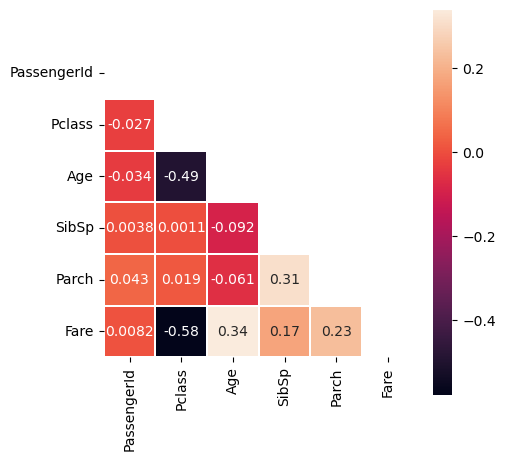

In [87]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, linewidth=0.3, annot=True, square=True,
           mask=mask)
plt.show()

The most correlated variables are Pclass and Fare, as expected. There does exist a weak correlation between Pclass and Survived, solidifying the claim that people who paid more were given priority. There does not appear to be any correlation between the Age of the person and his chances of survival, since the correlation between Age and Survived is close to 0.

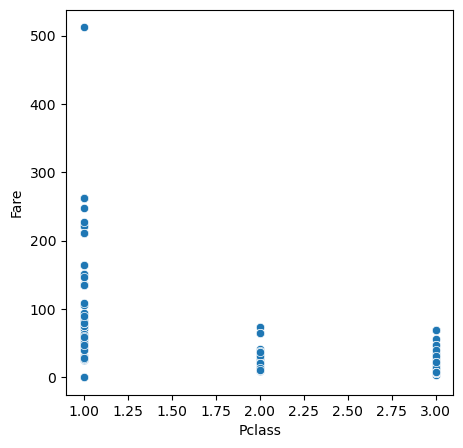

In [88]:
sns.scatterplot(df['Pclass'],df['Fare'])
plt.show()

Although Pclass is highly correlated with Fare, we cannot draw the conclusion that Pclass <i>encodes</i> Fare in its data. From the above scatter plot we can see that if a person paid less than 100, then it is unclear which Pclass he belongs to. Moreover, there does not appear to be any major distinction between Pclass 2 and 3.

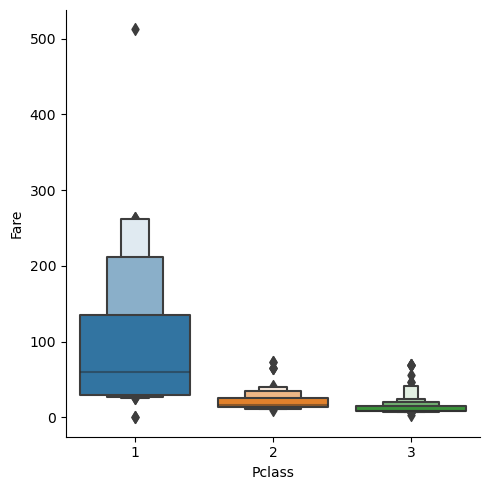

In [89]:
sns.catplot(x="Pclass", y="Fare", data=df, kind="boxen")
plt.show()

From the above cat plot, we can see that the majority of people in passenger class 1 paid between 25 and 100. People in this class paid significantly more than those in 2 and 3. The distinction between 2 and 3 is miniscule, however we can see that those in 2 paid slightly more than those in 3.

##### Let's explore the Embarked column.
Would we expect the port from which a passenger embarked on the Titanic from, to affect the chances of survival for that person?

In [90]:
try:
    FacetGrid = sns.FacetGrid(df, row='Embarked', aspect=2)
    FacetGrid.map(sns.pointplot, 'Pclass', 'Survived','Sex',
                  linestyles = '-.')
    FacetGrid.add_legend()
    plt.show()
except Exception as e:
    print('Skipping...')


Skipping...


From the above pointplots, we can see that embarking from Port Q has the worst survival chances for males,
but the best for women. Embarking from Port C gives the best chances of survival for men, but the worst for women. 
Pclass 3 seems to be the worst option. Survival rate always dips for both men and women, except for a slight increase for men who embarked from Port Q.

## Feature engineering the Fare Column
In order to make the data simpler, I will attempt to <i>bin</i> the Fare Column into some number of discrete groups. The end goal is to create a new column <i>Fare Category</i>, which would contain categorical values (Low, Mid, High) instad of continous numerical ones.

In [91]:
df[df.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


##### We have one passenger with NA values for Fare. Since it is only one, we can remove it.

In [92]:
df = df.dropna(subset=['Fare'])

##### Let's explore the distributions for Fare, before feature engineering the new column.

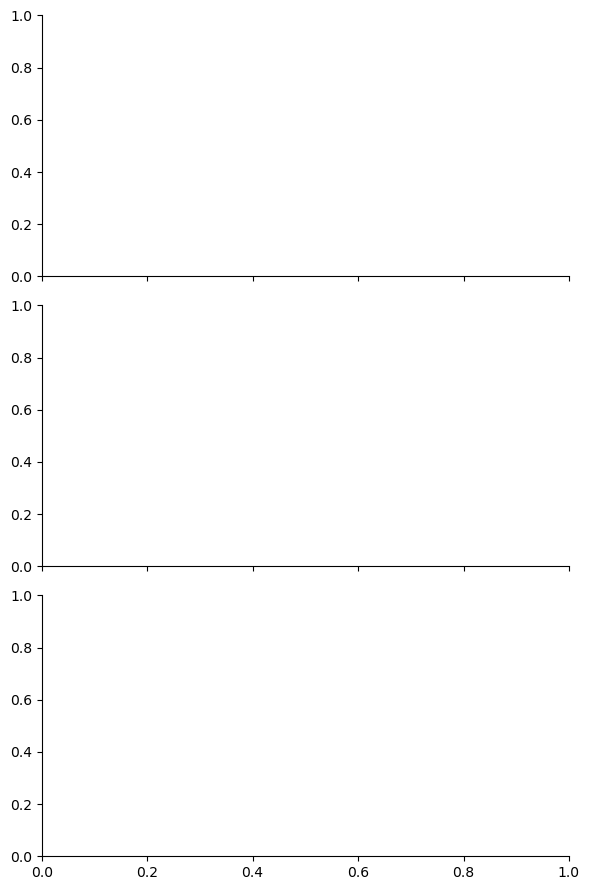

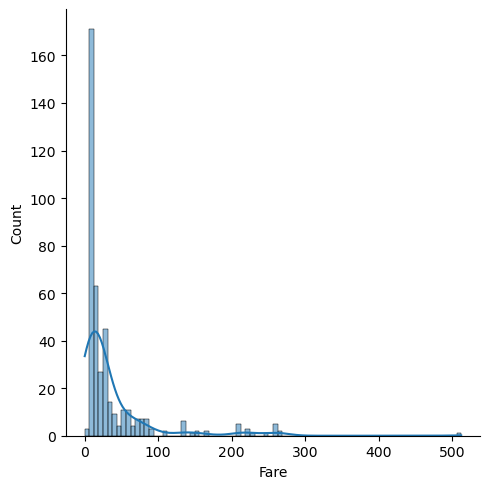

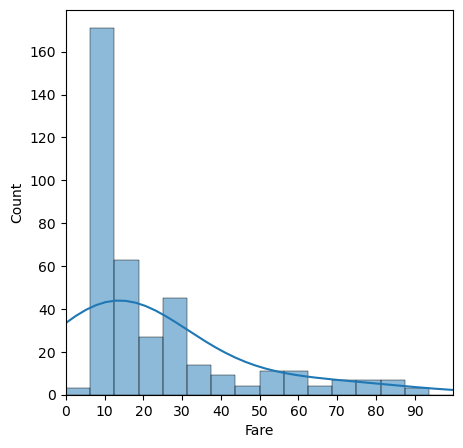

In [93]:
sns.displot(df["Fare"], kde=True)
plt.show()

fig,ax = plt.subplots()
sns.histplot(df["Fare"], kde=True, ax=ax)

ax.set_xlim(0,100)
ax.set_xticks(range(0,100,10))
plt.show()

##### In order to choose the bin ranges, first we will remove all outliers by only considering instances in the InterQuartile Range (IQR).
The bin ranges will be calulcated automatically by matplotlib's hist function

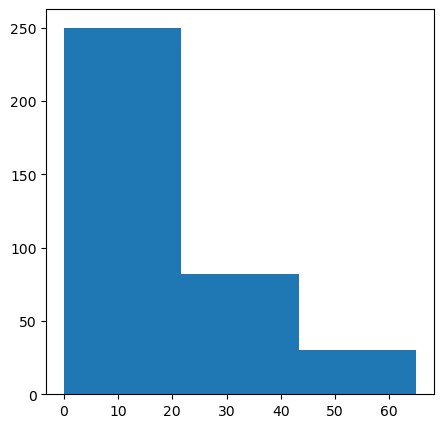

In [94]:
#Remove outliers to calculate bin ranges
Q1 = df['Fare'].quantile(0.25) 
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1

fare_categories = df['Fare'][~((df['Fare'] < (Q1 - 1.5 * IQR)) |(df['Fare'] > (Q3 + 1.5 * IQR)))]

ranges = plt.hist(fare_categories, bins=3)[1]
plt.show()

In [95]:
ranges[3] = float('inf') #Anything greater than the 2nd bin is in the 3rd bin.
ranges

array([ 0.        , 21.66666667, 43.33333333,         inf])

##### From the above plots, we can see that the majority of people paid between 0 and 22.
Using these ranges, we can feature engineer the new column <i>Fare_Category</i>
<ul>
<li>If a passenger's Fare was in the range [0,22], then <i>Fare_Category</i> would be 'Low' </li>
<li>If a passenger's Fare was in the range [22+,43], then <i>Fare_Category</i> would be 'Mid' </li>
<li>If a passenger's Fare was in the range [43+], then <i>Fare_Category</i> would be 'High' </li>
</ul>

In [96]:
df['Fare_Category'] = pd.cut(df['Fare'], bins=ranges, labels=['Low','Mid','High'])
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Category
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Low
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Low
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Low
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Low
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Low


##### Let's explore the new column.
How does the survival rate change for evey fare category?

In [97]:
try:

    low  = df[df["Fare_Category"] == "Low"]
    mid  = df[df["Fare_Category"] == "Mid"]
    high = df[df["Fare_Category"] == "High"]

    low_survived = low[low["Survived"] == 1].Survived.count()/low.Survived.count() * 100
    mid_survived = mid[mid["Survived"] == 1].Survived.count()/mid.Survived.count() * 100
    high_survived = high[high["Survived"] == 1].Survived.count()/high.Survived.count() * 100

    fig,ax = plt.subplots()

    plt.title('Survival Rate for every Fare Category')
    plt.xlabel("Fare Category")
    plt.ylabel("Survival Rate %")

    sns.barplot(x=["Low","Mid","High"], y=[low_survived,mid_survived,high_survived])
    sns.factorplot("Fare_Category", "Survived", data=df, aspect=2)
    plt.show()
except Exception as e:
    print('Skipping...')


Skipping...


It seems that the fare is positively correlated with your chances of survival. We have seen that passengers who paid more where more likely to belong to Pclass 1. Moreover, we know that Pclass 1 <i>tends</i> to have the highest survival rate across all values of Embarked & Sex. So this conclusion makes sense.

## Exploring SibSp and Parch
Siblings, spouses, parents and children can all be grouped into one column called <i>Family</i>. Using this new column, let's explore the survival rate across the number of family members.

In [98]:
df['Family'] = df['SibSp']+df['Parch']

In [99]:
try:
    max = int(df["Family"].max()+1)
    arr = [None]*max

    family = pd.DataFrame()

    for i in range(max):
        survived = len(df[(df["Family"]==i) & (df["Survived"]==1)])
        total = len(df[df["Family"]==i])

        arr[i] = survived/total * 100 if total > 0 else 0

    fig,ax = plt.subplots()

    plt.title('Survival Rate for different Family Sizes')
    plt.xlabel("Family Members")
    plt.ylabel("Survival Rate %")

    sns.barplot(x=[i for i in range(max)], y=arr)
    sns.factorplot('Family', 'Survived', data=df, aspect=2)
    sns.factorplot('Family', 'Survived', data=df, aspect=2, hue="Sex")
    plt.show()
except Exception as e:
    print('Skipping...')

Skipping...


From the above graphs we can infer that having 3 family members gives the highest chances of survival, for both men and women. Going forward, I will remove SibSp and Parch from the dataset later on, since <i>Family</i> will encode the same information.

### Imputing Age
Whenever we encounter a passenger with missing age, we will fill it with the average age of the people with the same <i>Family</i> and <i>Pclass</i> values. This is because <i>Pclass</i>, <i>SibSp</i> and <i>Parch</i> are the most correlated with Age.

In [100]:
df[(df.groupby(['Family','Pclass'])['Age'].transform('mean')).isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Category,Family


In [101]:
#Impute Age missing values by getting the average age for that person's Sex, Pclass and Survived value.

df['Age'] = df['Age'].fillna(df.groupby(['Family','Pclass'])['Age'].transform('mean'))

#Any instances left are removed
df = df.dropna(subset=['Age'])
df[df.Age.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Category,Family


## Adding Mother column
The Mother column will be a binary categorical variable. A passenger is considered to be a mother if:
<ul>
    <li> Passenger is female
    <li> Passenger is over 18
    <li> Passenger's salutation is Mrs.
    <li> Passenger has at least one Parent/Child
        
        

In [102]:
df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Category,Family
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q,Low,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S,Low,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q,Low,0
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S,Low,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S,Low,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,25.755319,0,0,A.5. 3236,8.0500,NaN,S,Low,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,High,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Low,0
416,1308,3,"Ware, Mr. Frederick",male,25.755319,0,0,359309,8.0500,NaN,S,Low,0


In [103]:
mother = []
for i,row in df.iterrows():
    
    if row['Sex'] == 'female' and\
       row['Age'] >= 18       and\
        "Mrs." in row['Name'] and\
        row['Parch'] > 1:
            
        mother.append(1)
    
    else: mother.append(0)
        
df['isMother'] = mother 

In [104]:
df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Category,Family,isMother
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q,Low,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S,Low,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q,Low,0,0
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S,Low,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S,Low,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,25.755319,0,0,A.5. 3236,8.0500,NaN,S,Low,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,High,0,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Low,0,0
416,1308,3,"Ware, Mr. Frederick",male,25.755319,0,0,359309,8.0500,NaN,S,Low,0,0


## Final cleaning

### Removing SibSp and Parch

In [105]:
df = df.drop(columns=['SibSp', 'Parch'])
df.head()

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Fare_Category,Family,isMother
0,892,3,"Kelly, Mr. James",male,34.5,330911,7.8292,NaN,Q,Low,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,363272,7.0000,NaN,S,Low,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,240276,9.6875,NaN,Q,Low,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,315154,8.6625,NaN,S,Low,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,3101298,12.2875,NaN,S,Low,2,0


### Removing Embarked NA values
Embarked is only missing once, so we can simply just remove that row.

In [106]:
df = df.dropna(subset=['Embarked'])
df.Embarked.isna().sum()

0

### Removing features
Ticket, Fare, Cabin and Name do not encode any information that can help the model predict whether a passenger will survive or not.

In [107]:
df = df.drop(['Ticket', 'Fare', 'Cabin', 'Name'],axis=1)

#Only remove PassengerId if data is Kaggle Train
if filepath == "kaggle_train.csv":
    df = df.drop(columns=['PassengerId'])


df.head()

,PassengerId,Pclass,Sex,Age,Embarked,Fare_Category,Family,isMother
0,892,3,male,34.5,Q,Low,0,0
1,893,3,female,47.0,S,Low,1,0
2,894,2,male,62.0,Q,Low,0,0
3,895,3,male,27.0,S,Low,0,0
4,896,3,female,22.0,S,Low,2,0


### Constraining float values to be integers

In [108]:
df['Age'] = df['Age'].round(0).astype(int)
df['Family'] = df['Family'].round(0).astype(int)
df['Pclass'] = df['Pclass'].round(0).astype(int)

In [109]:
try:
    df['Survived'] = df['Survived'].round(0).astype(int)
except Exception as e:
    print('Skipping...')

Skipping...


### Turning categorical values into numbers

In [110]:
df['Sex'] = df['Sex'].replace(['male','female'],[0,1])
df['Embarked'] = df['Embarked'].replace(['C','S','Q'],[0,1,2])
df['Fare_Category'] = df['Fare_Category'].replace(['Low','Mid','High'],[0,1,2])

### One-hot encoding categorical variables
It is general practice to one-hot encode categorical variables, as it makes the process easier during training.

In [111]:
#PClass
one_hot_Pclass = pd.get_dummies(df.Pclass)
one_hot_Pclass.columns =['Pclass_1','Pclass_2','Pclass_3']
one_hot_Pclass = one_hot_Pclass.drop(['Pclass_3'],axis=1)

#Embarked
one_hot_Embarked = pd.get_dummies(df.Embarked)
one_hot_Embarked.columns =['Embarked_1','Embarked_2','Embarked_3']
one_hot_Embarked = one_hot_Embarked.drop(['Embarked_3'],axis=1)

# #Fare_Category
one_hot_Fare_Category = pd.get_dummies(df.Fare_Category)
one_hot_Fare_Category.columns =['Fare_Category_1','Fare_Category_2','Fare_Category_3']
one_hot_Fare_Category = one_hot_Fare_Category.drop(['Fare_Category_3'],axis=1)

df = pd.concat([df,one_hot_Pclass, one_hot_Embarked, one_hot_Fare_Category],axis=1).drop(['Pclass','Embarked','Fare_Category'],axis=1)

df

,PassengerId,Sex,Age,Family,isMother,Pclass_1,Pclass_2,Embarked_1,Embarked_2,Fare_Category_1,Fare_Category_2
0,892,0,34,0,0,0,0,0,0,1,0
1,893,1,47,1,0,0,0,0,1,1,0
2,894,0,62,0,0,0,1,0,0,1,0
3,895,0,27,0,0,0,0,0,1,1,0
4,896,1,22,2,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,26,0,0,0,0,0,1,1,0
414,1306,1,39,0,0,1,0,1,0,0,0
415,1307,0,38,0,0,0,0,0,1,1,0
416,1308,0,26,0,0,0,0,0,1,1,0


### Saving

The feature-engineered dataset will be split into training and testing partitions.

In [112]:
# df.to_csv(os.path.join('..','..','data','Variant 1','titanic_cleaned.csv'), index=False)
# df.to_csv(os.path.join('..','..','data','Variant 1','kaggle_train_cleaned.csv'), index=False)
df.to_csv(os.path.join('..','..','data','Variant 1','kaggle_test_cleaned.csv'), index=False)